To compare TRI

Read each raster a X buffer 
Get the R2 and the RMSE from the metrics (error result file)
Plot each TRI histogram shape
Sumarize median


In [1]:
import rasterio
from matplotlib import pyplot
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime

dir_srtm='../data/shapes/TRI_nk/'

#### Exatract file names at X km buffer
##### Each file has a pattern name dem_<crs>_<buffer>_<lakeid>.tif. For example dem_wgs_5km_12327, DEM of a 5 km buffer for lake 12327, the coordinate reference system (crs) is wgs84

In [2]:
files = [f for f in os.listdir(dir_srtm) if os.path.isfile(os.path.join(dir_srtm, f))&(f.startswith('TRI')&f.endswith('.tif'))]
Xkm='5km' #Buffer
idx_lake=3 #Position of the lake id in the string 
files_Xkm=[f for f in files if Xkm in f]
#Example files_Xkm[0].split('_')[idx_lake].split('.')[0] #To extract only the lake id
files_Xkm_id=[f.split('_')[idx_lake].split('.')[0] for f in files_Xkm]
df_files=pd.DataFrame({'lake_id':files_Xkm_id,'file_name':files_Xkm}).sort_values(by='lake_id') 
# df_files.head()

In [5]:
#Calculating stats
#Open each raster file
#Obtain not null valiues
#Calculate the 95 percentile [This is to avoid extreme high values from the raster edges] 
#Generate two dataframes with all rasters. Each column has the TRI values of each lake buffer 
# rastervals contain values between 0 and the choosen percentile. 
# rastervals_all contain values greater than 0. 
#At the end calculate descriptive stast for all buffers (max, min, mean, median (p50), std, percentiles (25, 75, and the choosen percentile)

def open_tri_files(df_files, fn_fd, idx_lake, percentile=95):
    rastervals=pd.DataFrame()
    rastervals_all=pd.DataFrame()
    for f in df_files[fn_fd].values:
        # im=plt.subplot(row_f,col_f,nfig) 
    
        src = rasterio.open(dir_srtm+f)
        rvalues=src.read(1)
        notnan_rvalues=rvalues[~np.isnan(rvalues)]
        p=np.percentile(notnan_rvalues,percentile)
    
        st_id=f.split('_')[idx_lake].split('.')[0]
        vals_all=pd.DataFrame({st_id:rvalues[rvalues>0]})
        vals=pd.DataFrame({st_id:rvalues[(rvalues>0) & (rvalues<p)]})
        rastervals=pd.concat((rastervals,vals), axis=1)
        rastervals_all=pd.concat((rastervals_all,vals_all), axis=1)
        src.close()
    return rastervals_all, rastervals


In [6]:
percentile=95
fn_fd='file_name'
rastervals_all, rastervals=open_tri_files(df_files, fn_fd, idx_lake, percentile)

percentiles=[.25, .75, percentile/100]
df_stats=rastervals.describe(percentiles=percentiles).transpose().reset_index().sort_values(by='mean')
df_stats=df_stats.rename(columns={'index':'lake_id'})
df_stats_all=rastervals_all.describe(percentiles=percentiles).transpose().reset_index().sort_values(by='mean')
df_stats_all.rename(columns={'index':'lake_id'}, inplace=True)
# df_stats_all

In [12]:
#Save stats files. Format TRI_stats_<percentile>_<buffer>_<file_creation_date>
#For all data, instead of percentile is all
time_file=datetime.now().strftime("%Y%m%d_%H_%M")

df_stats.to_csv('../data/results/TRI_stats_'+str(percentile)+'_'+Xkm+'_'+time_file+'.csv', sep=',')
df_stats_all.to_csv('../data/results/TRI_stats_'+'all'+'_'+Xkm+'_'+time_file+'.csv', sep=',')

### Figures
#### 1. Differences between mean all values and mean values under percentile
#### 2. Histogram with and without values over choosen percentile
#### 3. Boxplot all the data in the raster

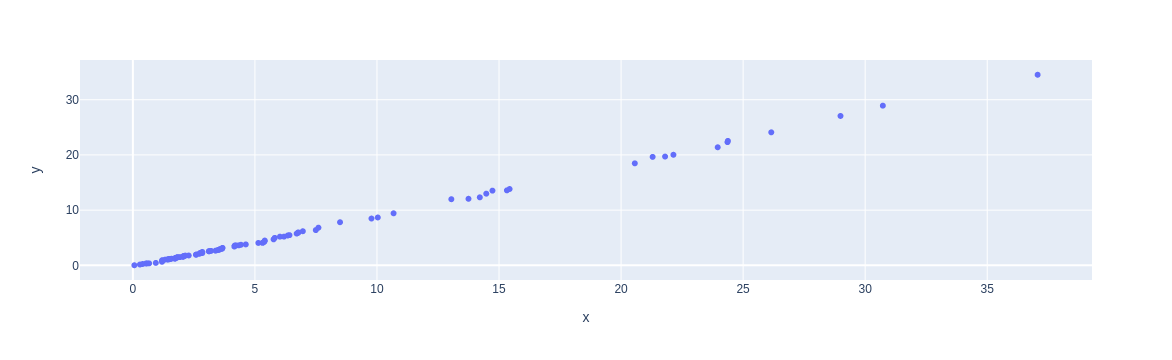

In [16]:
import plotly.express as px
fig = px.scatter(x=df_stats_all['mean'], y=df_stats['mean'])
fig.show()

In [22]:

def fig_histogram(df, items, row_f, col_f, color, names, save_fig):
    fig, axes = plt.subplots(nrows=row_f, ncols=col_f, figsize=(30, 30), sharex=True)
    ax=0
    ay=-1

    for f in items:
        rvalues=df[f]
        notnan_rvalues=rvalues[~np.isnan(rvalues)]
        lk_id=f
        if ay<col_f-1:
            ay+=1
            # if ax==row_f:
            # ax+=1
        else:
            ay=0
            ax+=1
        axes[ax][ay].hist(notnan_rvalues, color=color, ec=color, density=True)
        axes[ax][ay].set_title(names['sub_title_pref']+ lk_id)
    fig.tight_layout()   
    fig.suptitle(names['super_title'], fontsize=25)
    fig.subplots_adjust(top=0.95)

    if save_fig:
        plt.savefig(names['file_name'])
    plt.show()


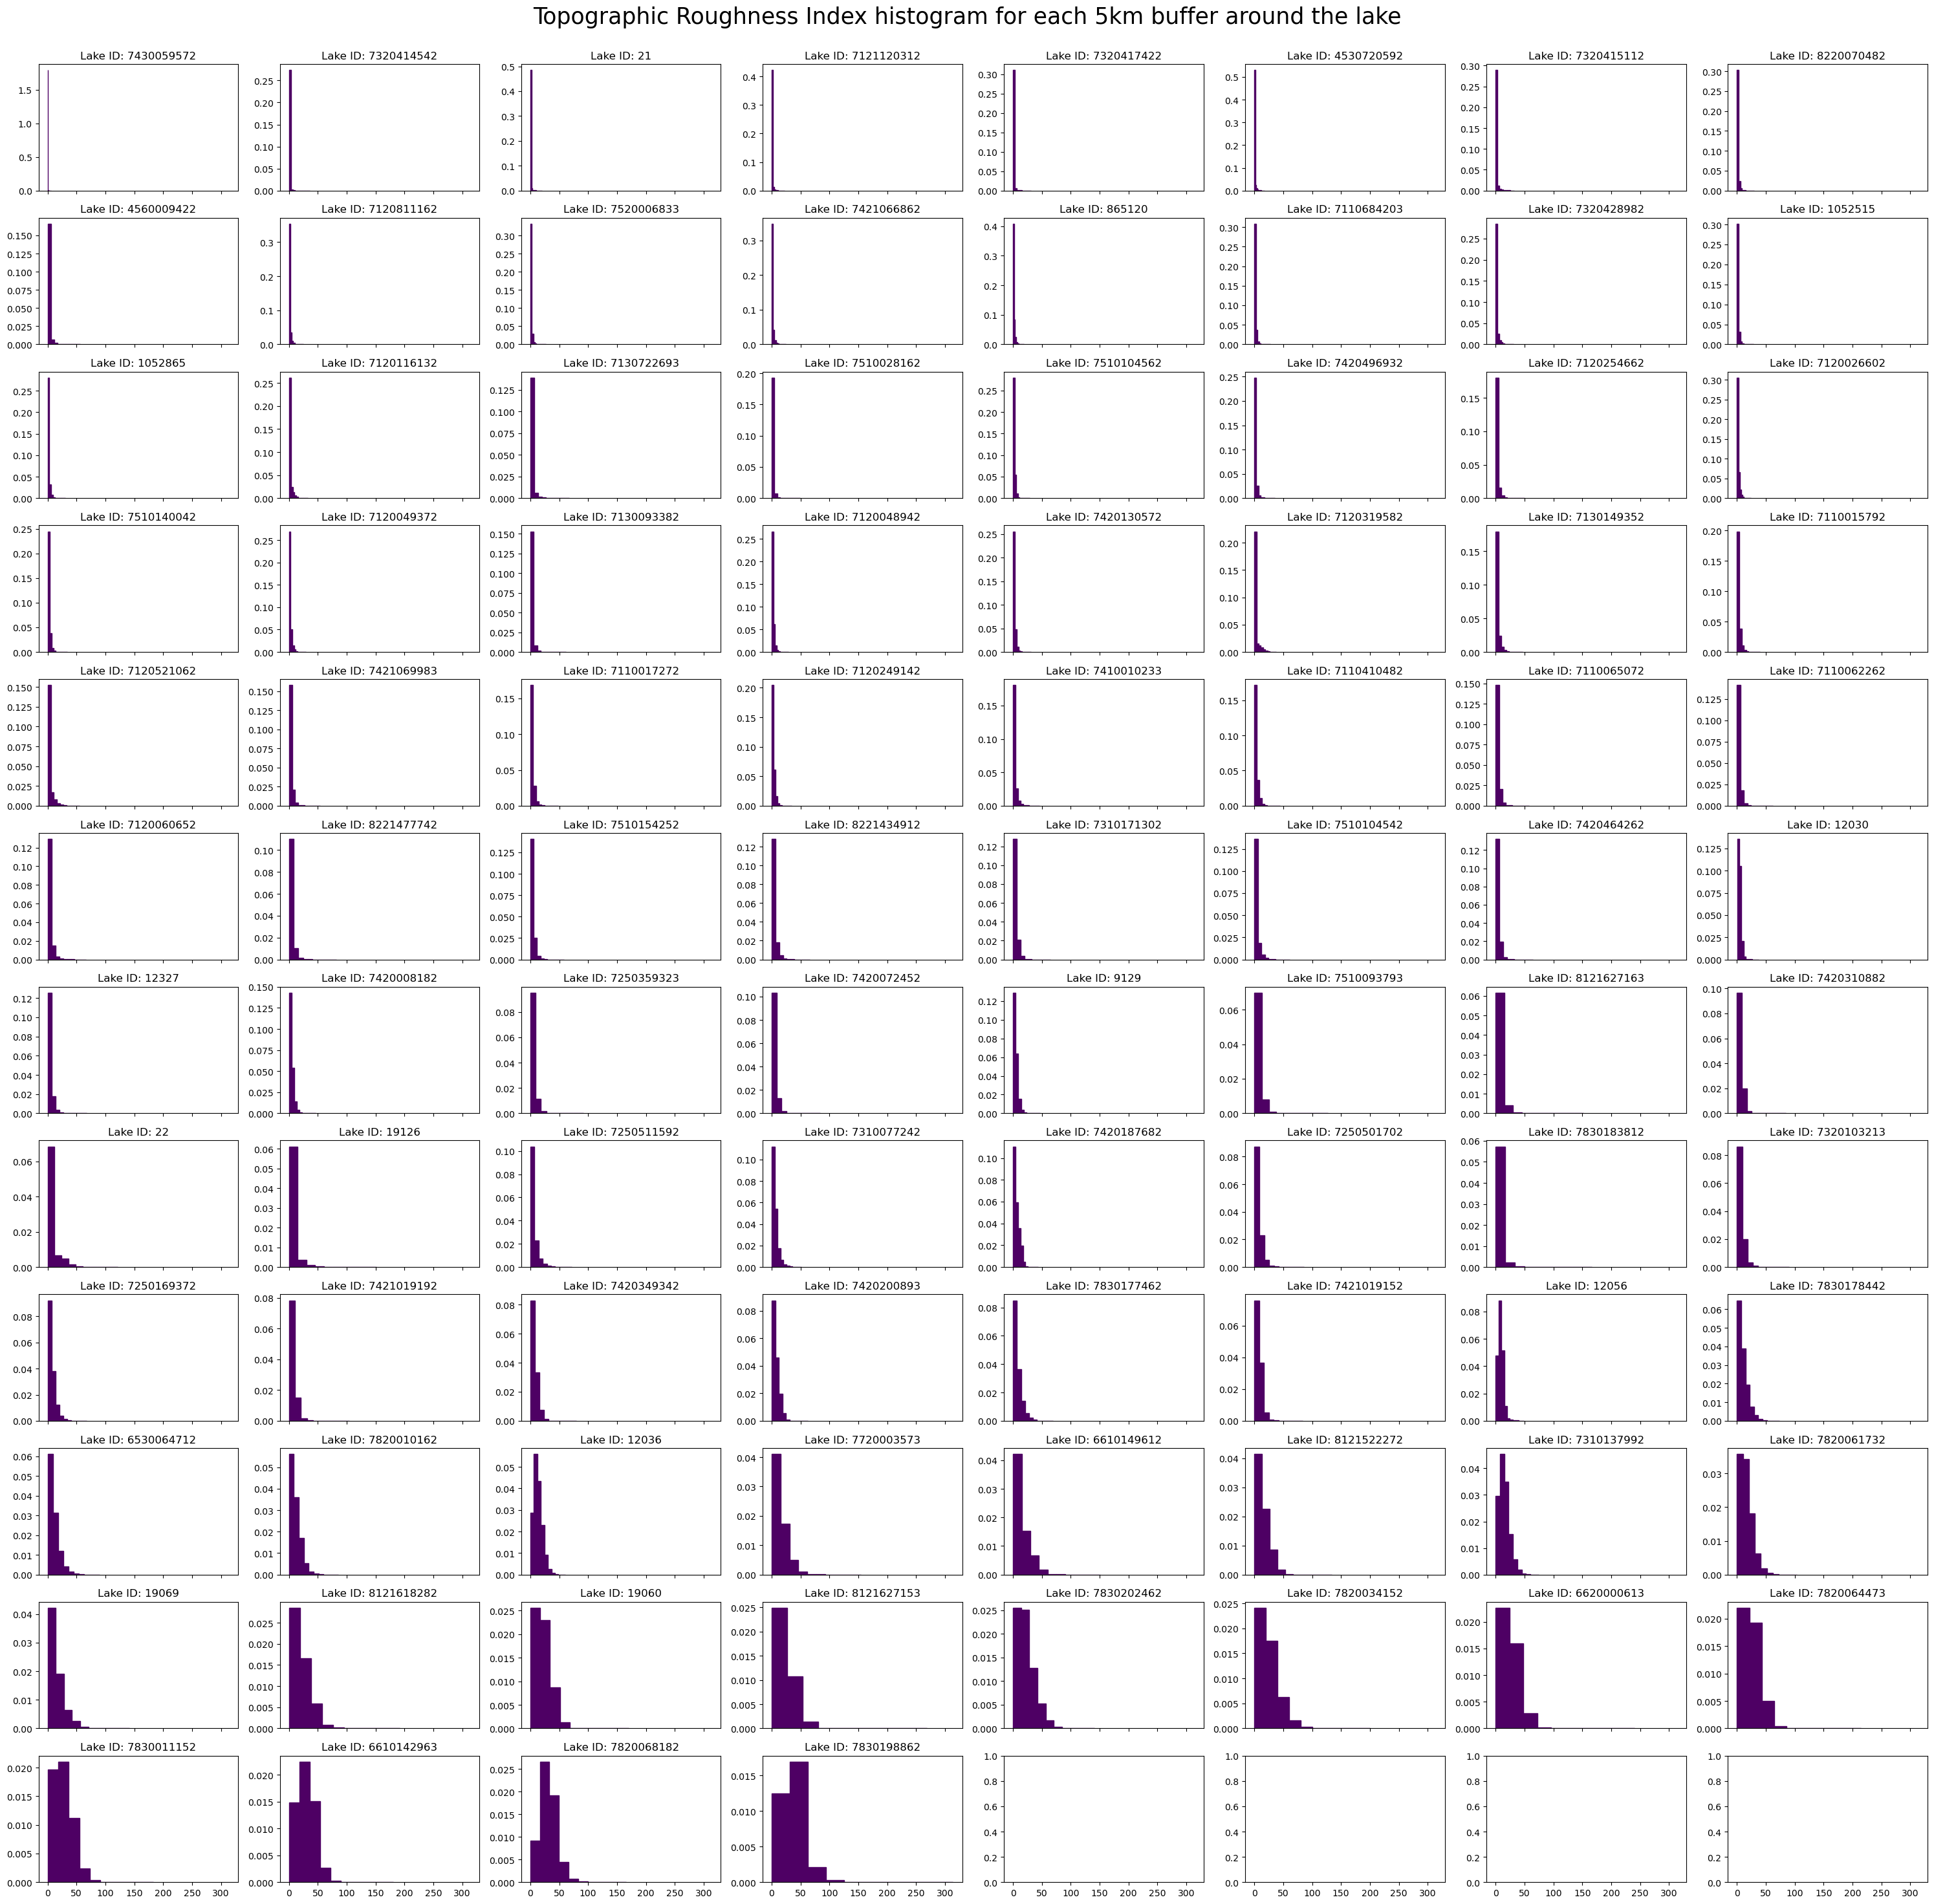

In [25]:
df=rastervals_all.copy()
items=df_stats_all['lake_id']
row_f=12
col_f=8
color='#4e0064'
names={'super_title':'Topographic Roughness Index histogram for each '+Xkm+' buffer around the lake',
       'sub_title_pref':'Lake ID: ',
       'file_name':'../data/results/TRI_histogram_with_all_at_'+Xkm+'_lakes.png'}
save_fig=True
fig_histogram(df, items, row_f, col_f, color, names, save_fig)

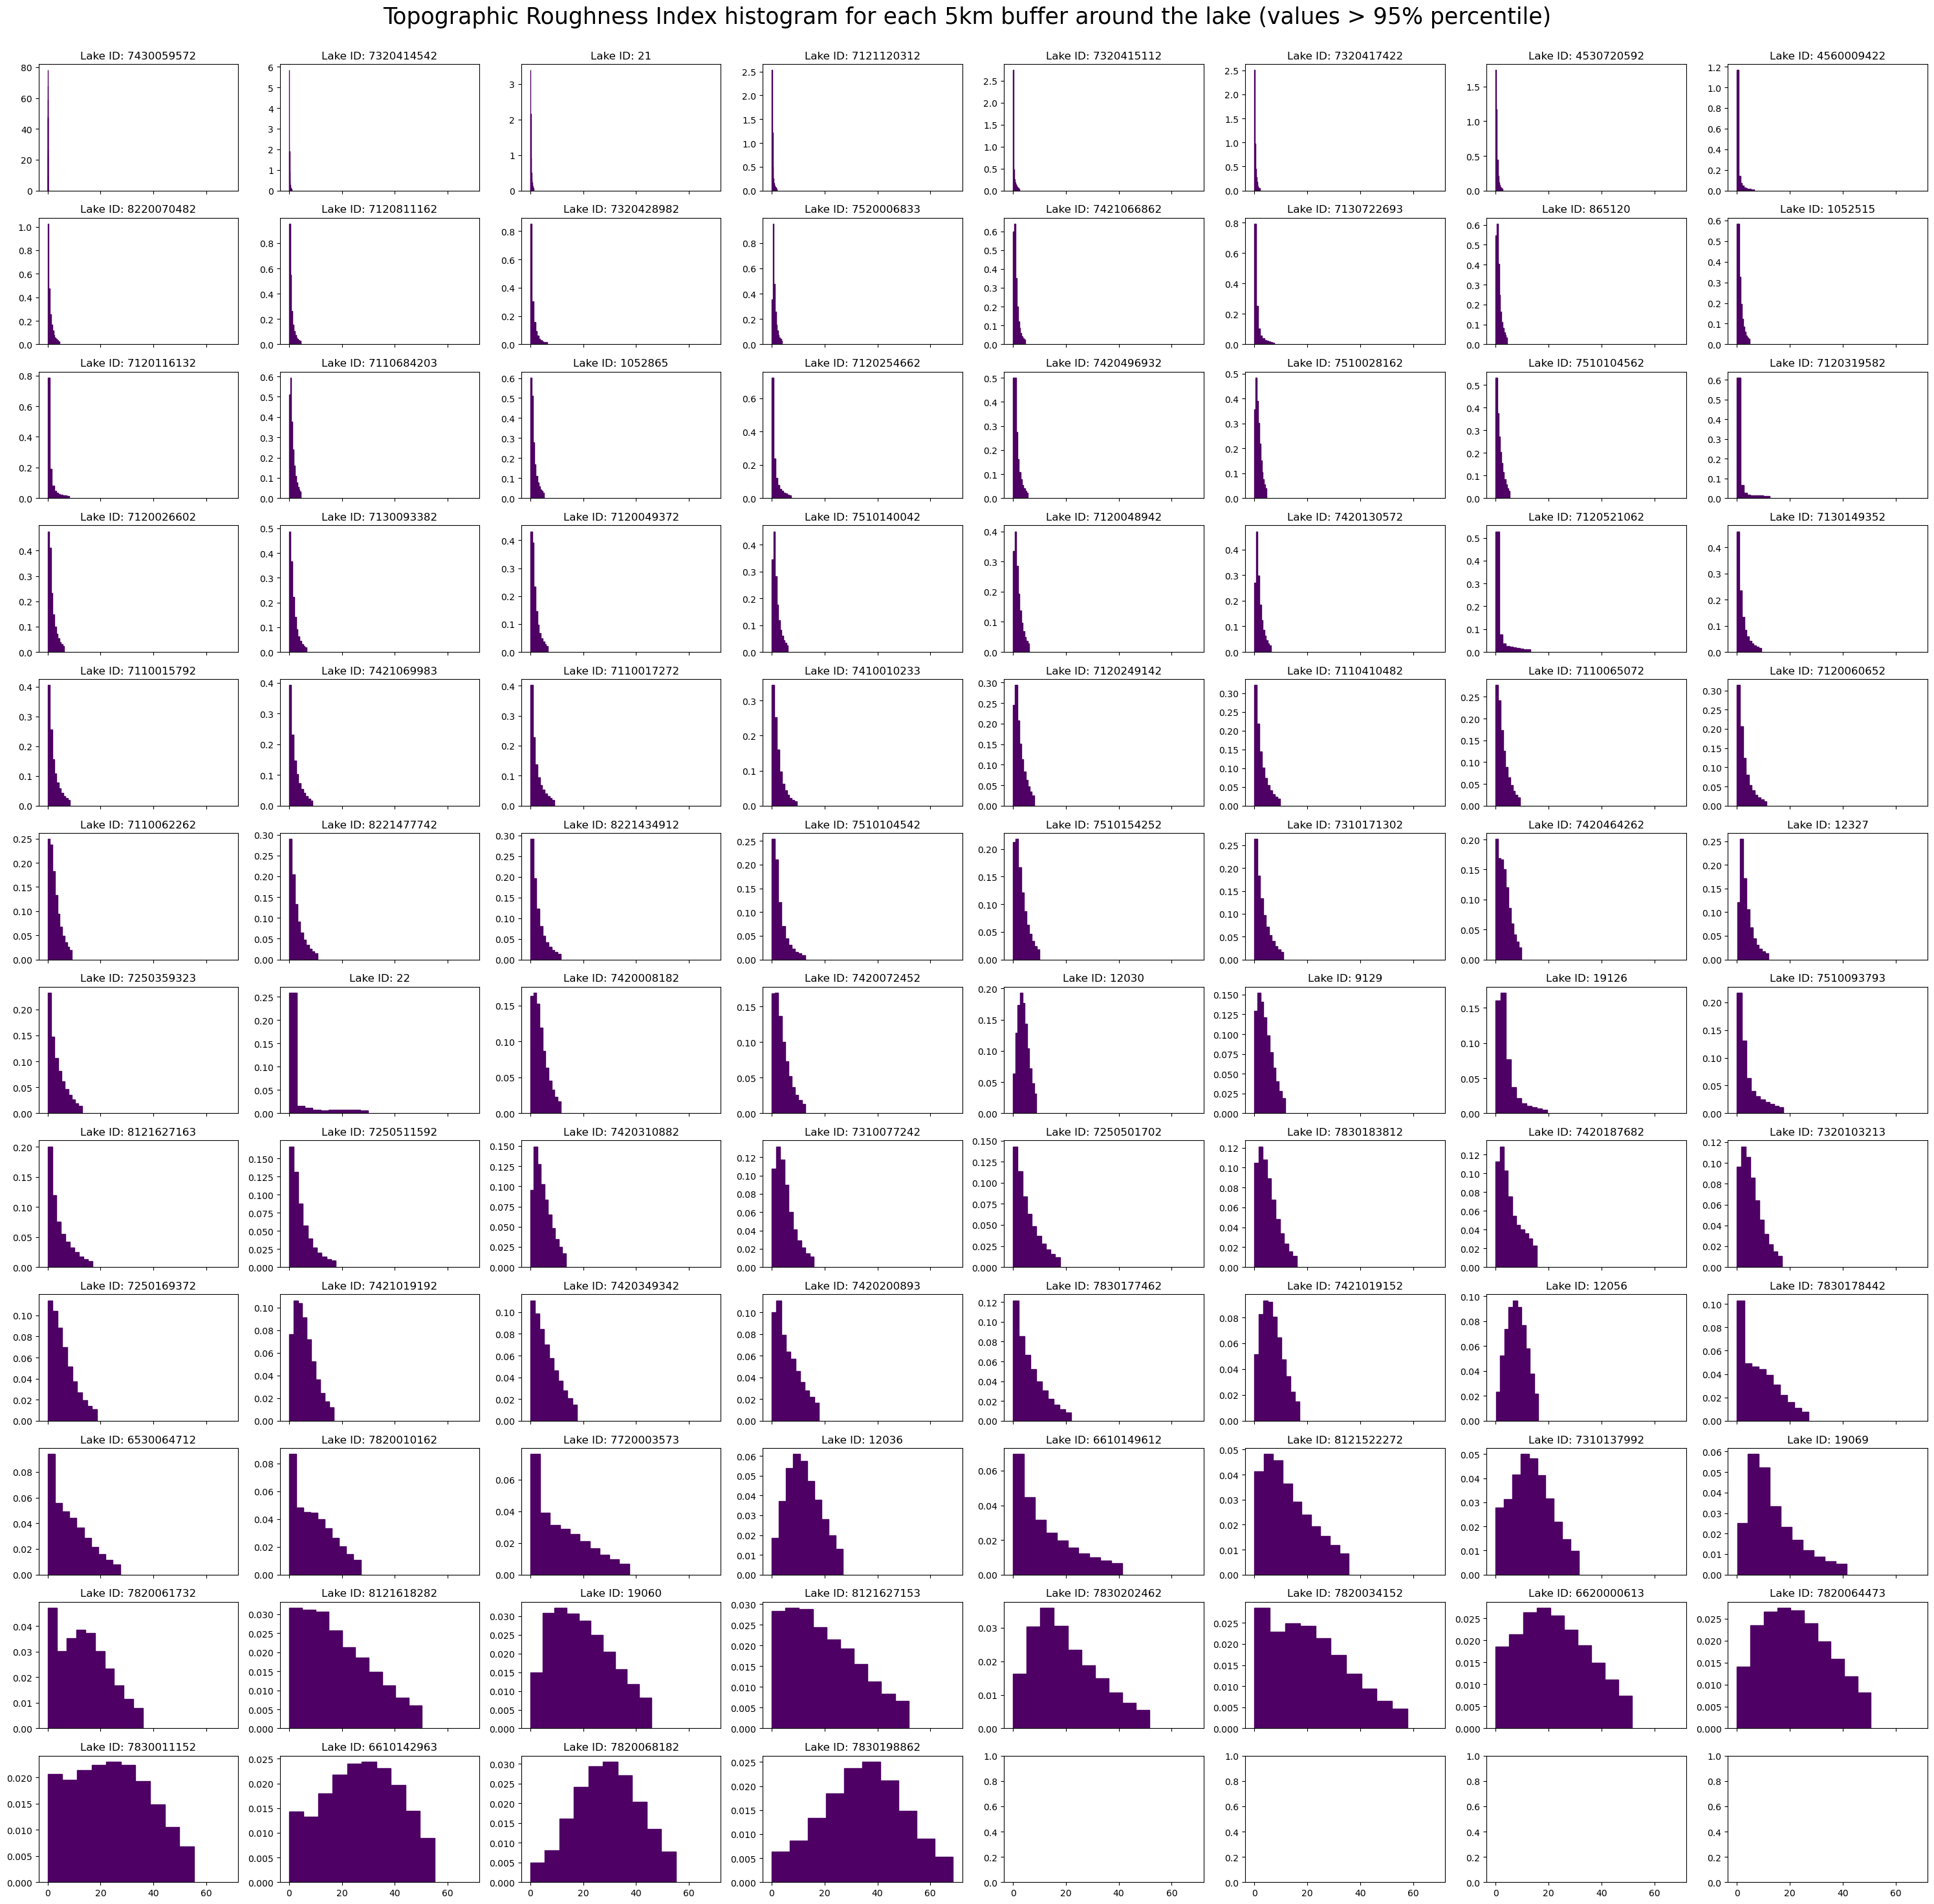

In [26]:
df=rastervals.copy()
items=df_stats['lake_id']
row_f=12
col_f=8
color='#4e0064'
names={'super_title':'Topographic Roughness Index histogram for each '+Xkm+' buffer around the lake (values > 95% percentile)',
       'sub_title_pref':'Lake ID: ',
       'file_name':'../data/results/TRI_histogram_with_'+str(percentile)+'_at_'+Xkm+'_lakes.png'}
save_fig=True
fig_histogram(df, items, row_f, col_f, color, names, save_fig)

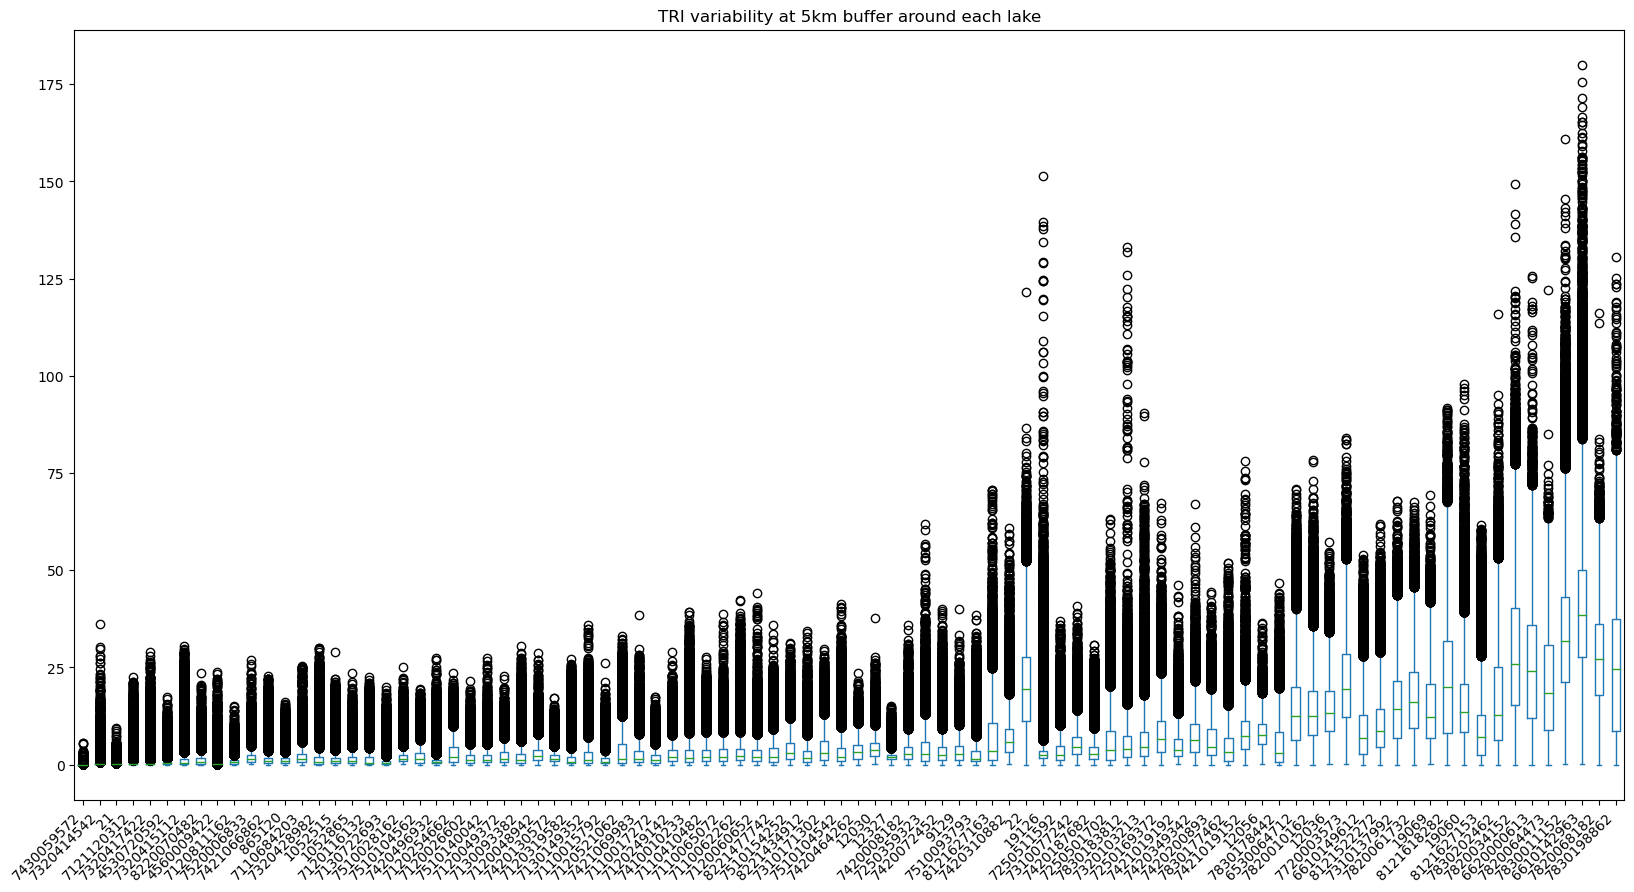

In [6]:
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [20, 10]

ax = rastervals_all[df_stats_all['lake_id'].values].dropna().plot(kind='box', title='TRI variability at '+Xkm+' buffer around each lake')
for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
        # title_obj = pyplot.title(f)
    # color_bar = pyplot.colorbar() 
plt.savefig('../data/results/TRI_'+Xkm+'buffer_lakes_variability_all.png')
plt.show()
    # nfig+=1

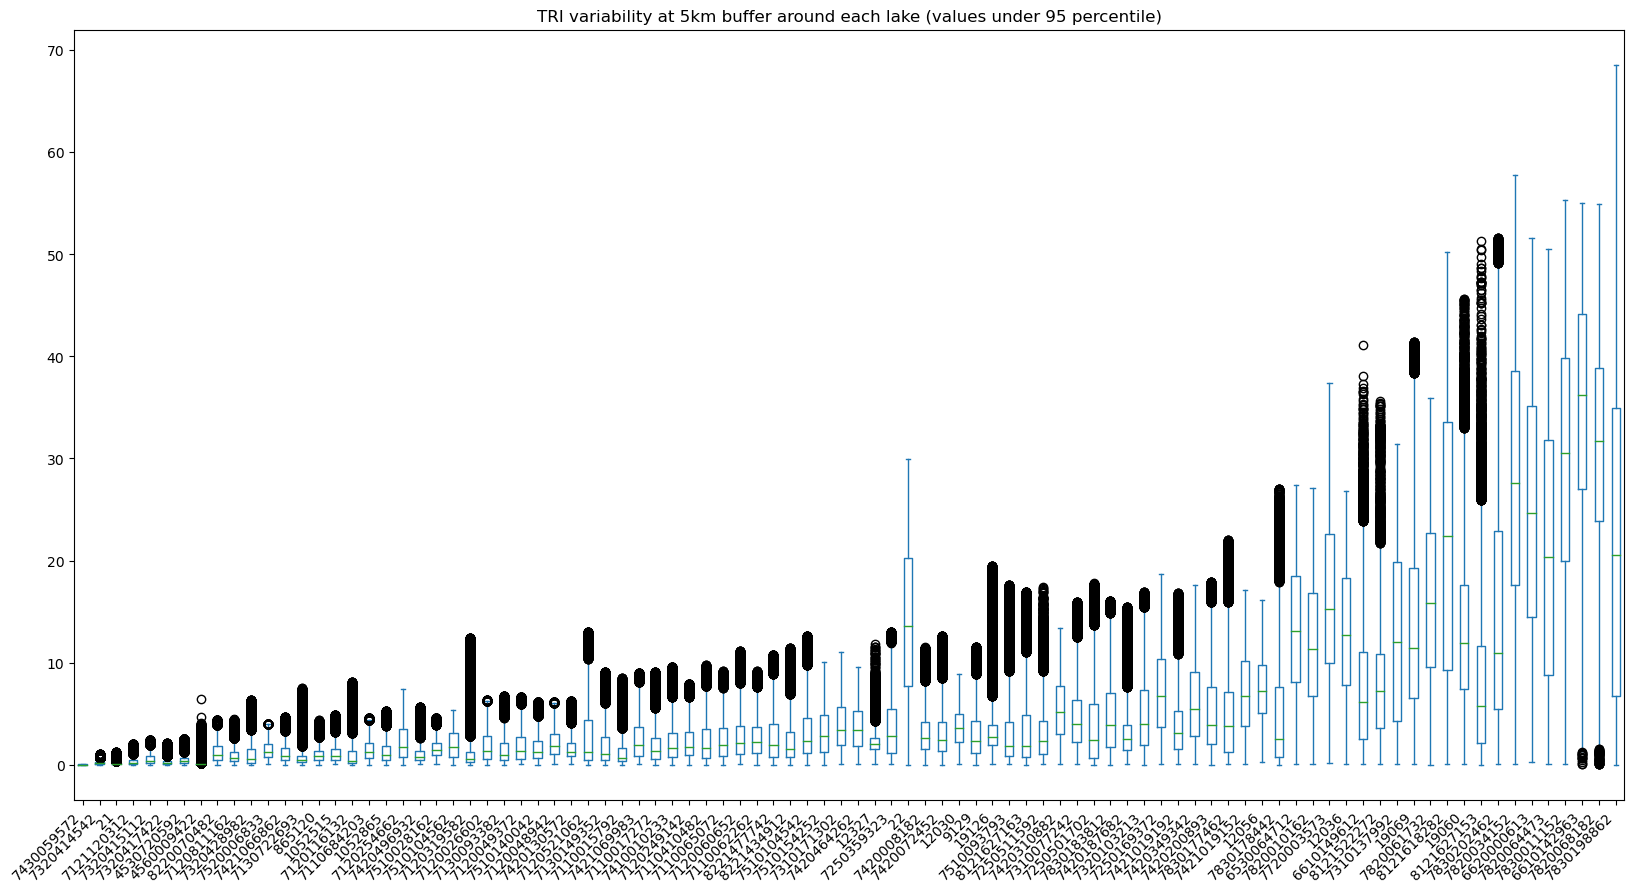

In [9]:
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [20, 10]

ax = rastervals[df_stats['lake_id'].values].dropna().plot(kind='box', title='TRI variability at '+Xkm+' buffer around each lake (values under '+str(percentile)+' percentile)')
for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
        # title_obj = pyplot.title(f)
    # color_bar = pyplot.colorbar() 
plt.savefig('../data/results/TRI_'+Xkm+'buffer_lakes_variability_'+str(percentile)+'.png')
plt.show()

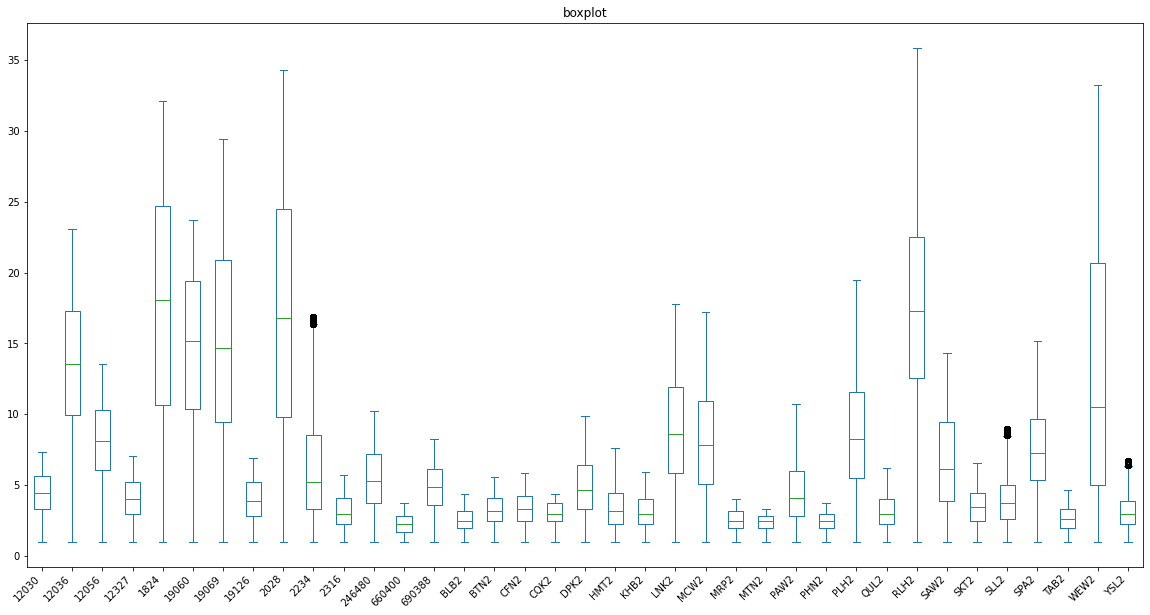

In [66]:
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [20, 10]

ax = rastervals.plot(kind='box', title='boxplot')
for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')
        # title_obj = pyplot.title(f)
    # color_bar = pyplot.colorbar() 
plt.savefig('../data/results/TRI_1km_lakes_variability.png')
plt.show()

ic| rvalues.shape: (528, 693)


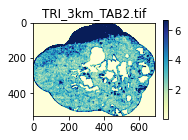

ic| rvalues.shape: (220, 302)


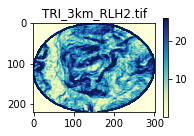

In [ ]:
from icecream import ic
row_f=2
col_f=2
nfig=1

fig, axes = plt.subplots(nrows=2, ncols=2)
fig = plt.figure(figsize=(20, 10))

for f in ['TRI_3km_TAB2.tif', 'TRI_3km_RLH2.tif']:
    im=plt.subplot(row_f,col_f,nfig) 
    src = rasterio.open(dir_srtm+f)
    rvalues=src.read(1)
    ic(rvalues.shape)
    p90=np.percentile(rvalues,90)
# rvalues=rvalues[(rvalues>0) & (rvalues<p90)]
# rvalues.shape
    pyplot.imshow(rvalues, cmap='YlGnBu',vmin=0.0001, vmax=p90)
    title_obj = pyplot.title(f)
    color_bar = pyplot.colorbar() 
    pyplot.show()